In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload 
%autoreload 2

import scipy.stats
import numpy as np

# The model and simulations.

To match with the INLA notation, the $\theta$ parameter for Berry et al 2013 is called $x$ here. Also, Berry uses:
\begin{equation}
\tilde{x} = logit(p) - logit(p_1)
\end{equation}
whereas we use:
\begin{equation}
x = logit(p) = \tilde{x} + logit(p_1)
\end{equation}

In [2]:
p0 = np.full(4, 0.1)  # rate of response below this is the null hypothesis
p1 = np.full(4, 0.3)  # rate of response above this is the alternative hypothesis.
# rate of response > p0 and < p1 is gray area.
p0_theta = scipy.special.logit(p0)

pmid = (p0 + p1) / 2
pmid_theta = scipy.special.logit(pmid)

# final evaluation criterion
# accept the alternative hypo if Pr(p[i] > p0|data) > pfinal_thresh[i]
pfinal_thresh = np.full(4, 0.85)

# early stopping criterion
pmid_accept = 0.9
pmid_fail = 0.05

null_x_berry = np.log(p0 / (1 - p0)) - np.log(p1 / (1 - p1))
null_x = np.log(p0 / (1 - p0))
prior_mu_mean = null_x[0]


In [3]:
def berry_prior(theta):
    mu = theta[..., 0]
    mu_prior = scipy.stats.norm.logpdf(mu, prior_mu_mean, 100)

    sigma2 = theta[..., 1]
    alpha = 0.0005
    beta = 0.000005
    sigma2_prior = scipy.stats.invgamma.logpdf(sigma2, alpha, scale=beta)
    return mu_prior + sigma2_prior


# Multidimensional numerical integration

We'd like to verify our INLA implementation. MCMC is an alternative that would give a rough verification. However, MCMC converges quite slowly so it's difficult to get nearly exact posterior estimates. Fortunately, the example problem that we are considering here has only six dimensions: two hyperparameters that control the sharing and four latent variables that describe the success of each trial arm. A six dimensional integral is feasible to compute numerically.

A fully robust implementation would use adaptive quadrature strategies and cover a much larger parameter domain. However, our goal is not to build a robust multi dimensional integration tool. Instead, our goal is to simply demonstrate that our INLA implementation is correct.

In [4]:
import inla

# I got this data by deconstructing the graphs in in Figure 1 of Berry et al 2013.
n_i = np.array([[i] * 4 for i in [10, 15, 20, 25, 30, 35]])
y_i = np.array(
    [
        [1, 6, 3, 3],
        [3, 8, 5, 4],
        [6, 9, 7, 5],
        [7, 10, 8, 7],
        [8, 10, 9, 8],
        [11, 11, 10, 9],
    ]
)
n_i = np.array([[10, 10, 10, 10], [15, 15, 15, 15], [20, 20, 20, 20], [20, 20, 25, 25], [20, 20, 30, 30], [20, 20, 35, 35]])
y_i = np.array([[0, 1, 3, 3], [0, 1, 4, 5], [0, 1, 6, 6], [0, 1, 6, 7], [0, 1, 7, 8], [0, 1, 9, 10]], dtype=np.float64)
data = np.stack((y_i, n_i), axis=2)

model = inla.binomial_hierarchical()
model.log_prior = berry_prior

mu_rule = inla.gauss_rule(41, -5, 3)
sigma2_rule = inla.composite_rule(
    inla.gauss_rule,
    (5, 1e-7, 1e-6),
    (5, 1e-6, 1e-5),
    (5, 1e-5, 1e-4),
    (5, 1e-4, 1e-3),
    (5, 1e-3, 1e-2),
    (5, 1e-2, 1e-1),
    (5, 1e-1, 1e0),
    (5, 1e0, 1e1),
    (5, 1e1, 1e2),
    (5, 1e2, 1e3),
)

In [5]:
MM, SS = np.meshgrid(mu_rule[0], sigma2_rule[0], indexing='ij')
theta = np.stack((MM.ravel(), SS.ravel()), axis=1)
x0_info = inla.optimize_x0(model, data[:1, None, :], theta[None, :])
xcenters = x0_info['x'][0].reshape((mu_rule[0].shape[0], sigma2_rule[0].shape[0], 4))
xcenters.shape

(41, 50, 4)

In [6]:
xstd = np.minimum(np.sqrt(sigma2_rule[0]), np.full_like(sigma2_rule[0], 2.0))
xmins = xcenters - 6 * xstd[None, :, None]
xmaxs = xcenters + 6 * xstd[None, :, None]

In [7]:
import quadpy
n = 11
q = quadpy.c1.gauss_legendre(n)
xpts = xmins[None, :, :, :] + (xmaxs[None, :, :, :] - xmins[None, :, :, :]) * (q.points[:, None, None, None] * 0.5 + 0.5)
xwts = q.weights[None, None, None, :] * (xmaxs[:, :, :, None] - xmins[:, :, :, None]) * 0.5
xpts.shape, xwts.shape

((11, 41, 50, 4), (41, 50, 4, 11))

In [8]:
%%time
x = np.transpose(np.array([[
    np.meshgrid(*[xpts[:,i,j,k] for k in range(4)], indexing='ij')
    for i in range(xpts.shape[1])]
    for j in range(xpts.shape[2])
]), (2, 3, 4, 5, 6, 1, 0))
grids = np.concatenate((
    x,
    np.broadcast_to(mu_rule[0][None,None,None,None,:,None], x.shape[1:])[None, :],
    np.broadcast_to(sigma2_rule[0][None,None,None,None,None,:], x.shape[1:])[None, :]
))
grids.shape

CPU times: user 283 ms, sys: 361 ms, total: 644 ms
Wall time: 646 ms


(6, 11, 11, 11, 11, 41, 50)

In [9]:
wts = np.array(
    [
        [
            xwts[i, j, 0, :, None, None, None]
            * xwts[i, j, 1, None, :, None, None]
            * xwts[i, j, 2, None, None, :, None]
            * xwts[i, j, 3, None, None, None, :]
            for i in range(xpts.shape[1])
        ]
        for j in range(xpts.shape[2])
    ]
)
wts = np.transpose(wts, (2, 3, 4, 5, 1, 0))
wts.shape

(11, 11, 11, 11, 41, 50)

In [10]:
giant_grid_x = grids[:4].reshape((4, -1)).T.copy()
giant_grid_theta = grids[4:6].reshape((2, -1)).T.copy()
joint_density = model.log_joint(model, giant_grid_x, data[0], giant_grid_theta)
joint_density

array([-105.10514675,  -88.51384811,  -83.09734993, ..., -324.41602581,
       -322.12950161, -320.95230328])

In [12]:
p.shape

(11, 11, 11, 11, 41, 50)

In [20]:
sigma2_rule[0][-3]

550.0

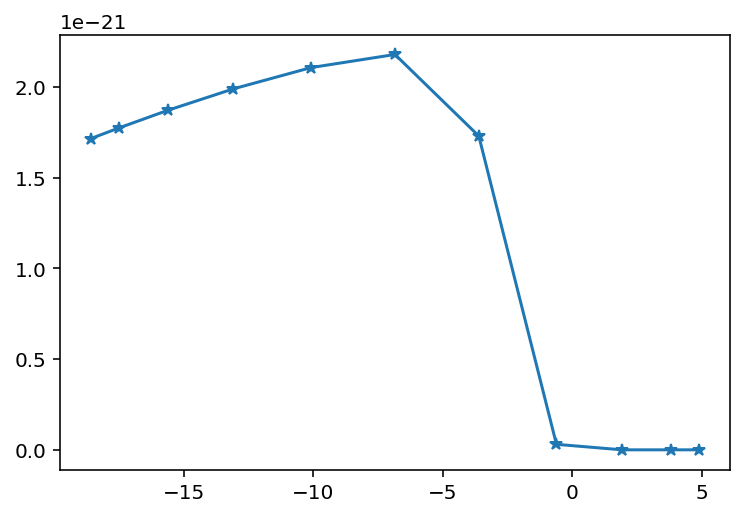

In [17]:
p = joint_density.reshape(grids[0].shape)
# for i in range(sigma2_rule[0].shape[0]):
idx = np.s_[:, 5, 5, 5, 20, -3]
plt.plot(grids[0][idx], np.exp(p[idx]), '-*')
plt.show()

In [77]:
mu_sig_marginal = np.sum(
    np.exp(joint_density.reshape(grids[0].shape)) * wts,
    axis=(0, 1, 2, 3),
)

In [78]:
total_wts = (
    wts
    * mu_rule[1][None, None, None, None, :, None]
    * sigma2_rule[1][None, None, None, None, None, :]
)
total_integral = np.sum(
    np.exp(joint_density.reshape(grids[0].shape)) * total_wts
)

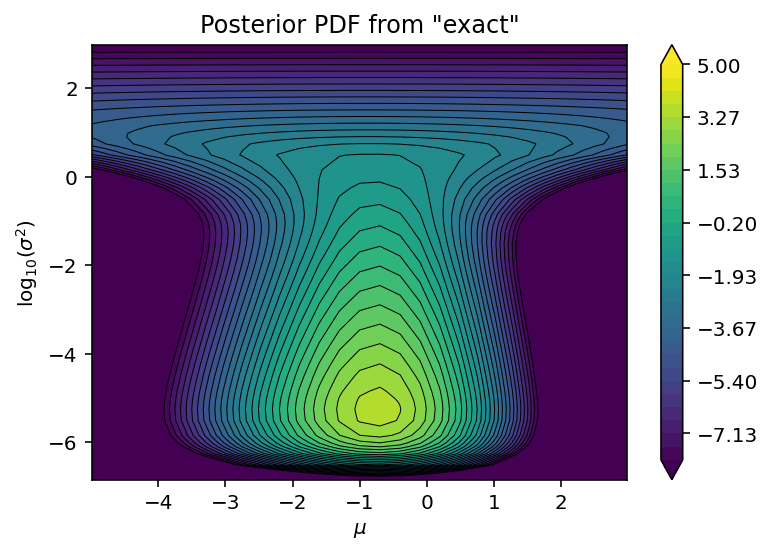

In [79]:
grid1 = grids[4][0, 0, 0, 0]
grid2 = np.log10(grids[5][0, 0, 0, 0])
field = np.log10(mu_sig_marginal / total_integral)
field[np.isnan(field) | np.isinf(field)] = -280
levels = np.linspace(-8, 5, 31)

cntf = plt.contourf(grid1, grid2, field, levels=levels, extend="both")
plt.contour(
    grid1,
    grid2,
    field,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
cbar = plt.colorbar(cntf)
# cbar.set_label(None)
plt.xlabel("$\mu$")
plt.ylabel("$\log_{10} (\sigma^2)$")
plt.title('Posterior PDF from "exact"')
plt.show()

# Sources of error

The goal of developing the "exact" integrator was to develop more confidence in our INLA and MCMC estimators. But, first we need to examine the error from this method.

There are three sources of error:
* $x$ domain error: we arbitrarily truncated the domain in order to numerically integrate. There are other quadrature rules that would handle an infinite domain, but they have their own complexities. Fortunately, we can estimate the quadrature error resulting from the finite domain by evaluating the integrand at the end points of the interval. 
* approximation error: we chose to use an 11 point quadrature rule in the latent variables. How much more accurate would the integral be if we had chosen a 12 point quadrature rule? Or a 20 point rule? For a smooth integrand, Gaussian quadrature will normally converge very quickly. 
* $\theta$ domain error: we truncated the range of sharing hyperparameters. This affects our density function because we need to normalize by the integral over the entire domain of hyperparameters. This $\theta$ domain error can be made consistent between the different methods we examine by using the same $\theta$ grid in the INLA calculations. This error is also the easiest form of error to control by a user because it is very obvious when a PDF is still large at the edge of the domain. So, we ignore this source of error. 


First, we'll examine the $x$ domain

In [80]:
def exact_integrate(n_mu, n_sigma2, n_x):
    mu_rule = inla.gauss_rule(n_mu, -5, 3)
    sigma2_rule = inla.composite_rule(
        inla.gauss_rule,
        (n_sigma2, 1e-7, 1e-6),
        (n_sigma2, 1e-6, 1e-5),
        (n_sigma2, 1e-5, 1e-4),
        (n_sigma2, 1e-4, 1e-3),
        (n_sigma2, 1e-3, 1e-2),
        (n_sigma2, 1e-2, 1e-1),
        (n_sigma2, 1e-1, 1e0),
        (n_sigma2, 1e0, 1e1),
        (n_sigma2, 1e1, 1e2),
    )
    MM, SS = np.meshgrid(mu_rule[0], sigma2_rule[0], indexing='ij')
    theta = np.stack((MM.ravel(), SS.ravel()), axis=1)
    x0_info = inla.optimize_x0(model, data[:1, None, :], theta[None, :])
    xcenters = x0_info['x'][0].reshape((mu_rule[0].shape[0], sigma2_rule[0].shape[0], 4))
    xstd = np.minimum(np.sqrt(sigma2_rule[0]), np.full_like(sigma2_rule[0], 2.0))
    xmins = xcenters - 3 * xstd[None, :, None]
    xmaxs = xcenters + 3 * xstd[None, :, None]

    q = quadpy.c1.gauss_legendre(n_x)
    xpts = xmins[None, :, :, :] + (xmaxs[None, :, :, :] - xmins[None, :, :, :]) * (q.points[:, None, None, None] * 0.5 + 0.5)
    xwts = q.weights[None, None, None, :] * (xmaxs[:, :, :, None] - xmins[:, :, :, None]) * 0.5
    x = np.transpose(np.array([[
        np.meshgrid(*[xpts[:,i,j,k] for k in range(4)], indexing='ij')
        for i in range(xpts.shape[1])]
        for j in range(xpts.shape[2])
    ]), (2, 3, 4, 5, 6, 1, 0))

    grids = np.concatenate((
        x,
        np.broadcast_to(mu_rule[0][None,None,None,None,:,None], x.shape[1:])[None, :],
        np.broadcast_to(sigma2_rule[0][None,None,None,None,None,:], x.shape[1:])[None, :]
    ))
    wts = np.array(
        [
            [
                xwts[i, j, 0, :, None, None, None]
                * xwts[i, j, 1, None, :, None, None]
                * xwts[i, j, 2, None, None, :, None]
                * xwts[i, j, 3, None, None, None, :]
                for i in range(xpts.shape[1])
            ]
            for j in range(xpts.shape[2])
        ]
    )
    wts = np.transpose(wts, (2, 3, 4, 5, 1, 0))

    giant_grid_x = grids[:4].reshape((4, -1)).T.copy()
    giant_grid_theta = grids[4:6].reshape((2, -1)).T.copy()
    joint_density = model.log_joint(model, giant_grid_x, data[0], giant_grid_theta)
    total_wts = (
        wts
        * mu_rule[1][None, None, None, None, :, None]
        * sigma2_rule[1][None, None, None, None, None, :]
    )

    total_integral = np.sum(
        np.exp(joint_density.reshape(grids[0].shape)) * total_wts
    )
    print(np.sum(total_wts))
    return total_integral

[
    exact_integrate(11, 4, n_x)
    for n_x in range(5, 20, 2)
]

16202291.469065243
16202291.469065264
16202291.46906525
16202291.469065249
16202291.469065255
16202291.46906527
16202291.469065247
16202291.469065271


[2.295336042469958e-14,
 1.3969170310605128e-14,
 1.2056472847620168e-14,
 1.1530147943999797e-14,
 1.1367826696765088e-14,
 1.1316248965257196e-14,
 1.1300449409257151e-14,
 1.1295997136152722e-14]

In [81]:
Is = _

In [85]:
Is = np.array(Is)
rel_err = np.abs(Is[1:] - Is[:-1]) / np.abs(Is[1:])
rel_err

array([6.43144146e-01, 1.58644861e-01, 4.56477147e-02, 1.42790044e-02,
       4.55784701e-03, 1.39813519e-03, 3.94146090e-04])